# Regression and Other Stories: Height and weight

Predict weight from height. See Chapters 3, 9 and 10 in Regression and Other Stories.

----

### Load Packages

In [1]:
using DataFrames, StatsPlots, CSV, HTTP, StatsBase
using Distributions, Turing, MCMCChains, CategoricalArrays

### Load Data

In [2]:
data = "https://raw.githubusercontent.com/avehtari/ROS-Examples/master/Earnings/data/earnings.csv"
earnings  = CSV.File(HTTP.get(data).body, delim=",", missingstring="NA") |> DataFrame
first(earnings , 6)

,height,weight,male,earn,earnk,ethnicity,education,mother_education
,Int64,Int64?,Int64,Float64,Float64,String,Int64?,Int64?
1,74,210,1,50000.0,50.0,White,16,16
2,66,125,0,60000.0,60.0,White,16,16
3,64,126,0,30000.0,30.0,White,16,16
4,65,200,0,25000.0,25.0,White,17,17
5,63,110,0,50000.0,50.0,Other,16,16
6,68,165,0,62000.0,62.0,Black,18,18


The original notebook doesn't address missing values, `stan_glm` appears to drop them. Turing's fitting method requires complete cases, so we have to manually drop missing values.

In [3]:
height_weight = earnings[!,[:height, :weight]]
hw_complete= dropmissing(height_weight);
println("Entries lost: ", size(earnings)[1] - size(hw_complete)[1])

Entries lost: 27


## Simulating uncertainty for linear predictors and predicted values

### Predict weight (in pounds) from height (in inches)

In [4]:
@model function m1(h, w)
    
    # Variance
    σ ~ truncated(Normal(0,100), 0, Inf)
    
    # Linear
    α ~ Normal(0, 500)
    β ~ Normal(0, 10)
    
    μ = α .+ h * β
    w ~ MvNormal(μ, σ)
end;

In [5]:
model1 = m1(hw_complete.height, hw_complete.weight)
chain1 = sample(model1, NUTS(), 4000)
summarystats(chain1)

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\tburch\.julia\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\tburch\.julia\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\tburch\.julia\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, true, false)
└ @ AdvancedHMC C:\Users\tburch\.julia\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.0015625
└ @ Turing.Inference C:\Users\tburch\.julia\packages\Tur

Summary Statistics
  parameters        mean       std   naive_se      mcse         ess      rhat  ⋯
      Symbol     Float64   Float64    Float64   Float64     Float64   Float64  ⋯

           α   -173.6926   12.3091     0.1946    0.3491   1236.3591    1.0023  ⋯
           β      4.9557    0.1844     0.0029    0.0052   1239.8420    1.0023  ⋯
           σ     28.9893    0.4760     0.0075    0.0100   1774.5284    0.9998  ⋯
                                                                1 column omitted


**Predict weight for a 66 inch person

In [6]:
coefs_1 = get(chain1, [:α, :β, :σ])
predicted_1 = mean(coefs_1.α) + mean(coefs_1.β) * 66

println(
    string("Predicted weight for a 66-inch-tall person is ", predicted_1 |> x->round(x, digits=1), 
        " pounds with a sd of ", coefs_1.σ |> mean |> round 
        )
)

Predicted weight for a 66-inch-tall person is 153.4 pounds with a sd of 29.0


### Center Heights

In [7]:
hw_complete[!,"c_height"] = hw_complete.height .- 66
model2 = m1(hw_complete.c_height, hw_complete.weight)
chain2 = sample(model2, NUTS(0.50), 4000)
summarystats(chain2)

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\tburch\.julia\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\tburch\.julia\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\tburch\.julia\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\tburch\.julia\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)

Summary Statistics
  parameters       mean       std   naive_se      mcse         ess      rhat   ⋯
      Symbol    Float64   Float64    Float64   Float64     Float64   Float64   ⋯

           α   153.3743    0.6779     0.0107    0.0100   4997.6470    0.9999   ⋯
           β     4.9456    0.1748     0.0028    0.0021   5045.2248    0.9998   ⋯
           σ    28.9800    0.4809     0.0076    0.0052   4868.1201    0.9998   ⋯
                                                                1 column omitted


### Point Prediction

In [8]:
point_pred_val = [4.0]
mpred = m1(point_pred_val, missing);
p=predict(mpred, chain2)
p["w[1]"].data |> mean |> x->round(x,digits=1)

173.3

### Posterior simulations

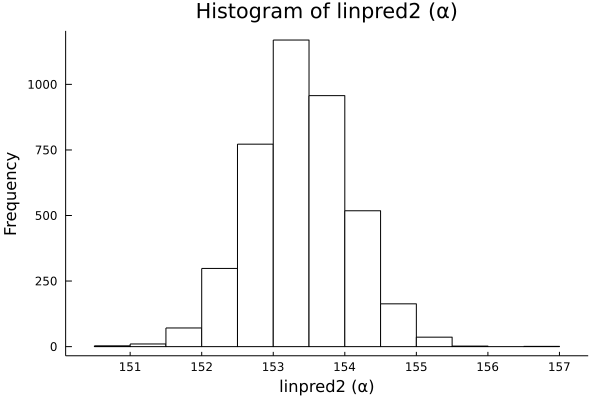

In [9]:
histogram(
    get(chain2, [:α]).α.data, 
    xlabel="linpred2 (α)",
    ylabel="Frequency",
    title="Histogram of linpred2 (α)",
    legend=false,
    bins=15,
    color=:white,
    grid=false
)

### Posterior predictive simulations

variation coming from posterior uncertainty in the coefficients

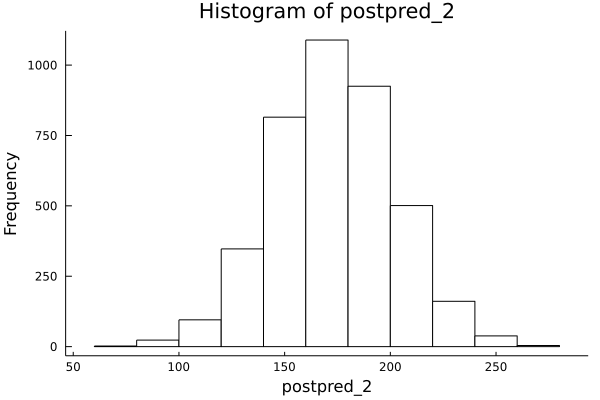

In [10]:
histogram(
    p["w[1]"].data,
    xlabel="postpred_2",
    ylabel="Frequency",
    title="Histogram of postpred_2",
    legend=false,
    bins=15,
    color=:white,
    grid=false
)

## Indicator Variables

### Predict weight (in pounds) from height (in inches)


In [11]:
println(
    string("Predicted weight for a 66-inch-tall person is ", predicted_1 |> x->round(x, digits=1), 
        " pounds with a sd of ", coefs_1.σ |> mean |> round 
        )
)

Predicted weight for a 66-inch-tall person is 153.4 pounds with a sd of 29.0


Again, take care of complete cases

In [12]:
height_weight_male = earnings[!,[:height, :weight, :male]]
hwm_complete= dropmissing(height_weight_male);
hwm_complete[!,"c_height"] = hwm_complete.height .- 66
println("Entries lost: ", size(earnings)[1] - size(hwm_complete)[1])

Entries lost: 27


### Include a binary variable in a regression

In [13]:
@model function m2(h,m,w)
    
    # Variance
    σ ~ truncated(Normal(0,100), 0, Inf)
    
    # Linear
    α ~ Normal(0, 500)
    β_c_height ~ Normal(0, 10)
    β_male ~ Normal(0, 10)
    
    μ = α .+ h * β_c_height .+ m * β_male
    w ~ MvNormal(μ, σ)
end;

In [14]:
model3 = m2(hwm_complete.c_height, hwm_complete.male, hwm_complete.weight)
chain3 = sample(model3, NUTS(), 4000)
summarystats(chain3)

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\tburch\.julia\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\tburch\.julia\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\tburch\.julia\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\tburch\.julia\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)

Summary Statistics
  parameters       mean       std   naive_se      mcse         ess      rhat   ⋯
      Symbol    Float64   Float64    Float64   Float64     Float64   Float64   ⋯

           α   149.6313    0.9153     0.0145    0.0184   2404.0668    0.9998   ⋯
  β_c_height     3.9207    0.2448     0.0039    0.0049   2373.6508    1.0002   ⋯
      β_male    11.4866    1.8985     0.0300    0.0411   2173.9512    0.9998   ⋯
           σ    28.6944    0.4802     0.0076    0.0088   2961.0024    0.9998   ⋯
                                                                1 column omitted


In [15]:
mpred2 = m2([4], [0], missing);
p2=predict(mpred2, chain3)

Chains MCMC chain (4000×1×1 Array{Float64, 3}):

Iterations        = 1:4000
Thinning interval = 1
Chains            = 1
Samples per chain = 4000
parameters        = w[1]
internals         = 

Summary Statistics
  parameters       mean       std   naive_se      mcse         ess      rhat 
      Symbol    Float64   Float64    Float64   Float64     Float64   Float64 

        w[1]   165.5930   28.3295     0.4479    0.4343   4014.2655    0.9998

Quantiles
  parameters       2.5%      25.0%      50.0%      75.0%      97.5% 
      Symbol    Float64    Float64    Float64    Float64    Float64 

        w[1]   108.8485   146.7965   165.2019   183.6276   222.5793


In [16]:
println(
    string("Predicted weight for a 70-inch-tall female is ", p2["w[1]"].data |> mean |> round, 
        " pounds with a sd of ",  p2["w[1]"].data |> std |> round
        )
)

Predicted weight for a 70-inch-tall female is 166.0 pounds with a sd of 28.0


### Using indicator variables for multiple levels of a categorical predictor

Include ethnicity in the regression as a factor. The original notebook goes through 3 examples of encoding a factor variable in R. Below, one method is demonstrated in Julia, employing `StatsBase.indicatormat` to one-hot-encode, and directly input the indicators into the model.

In [17]:
@model function m3(h, m, eth_black, eth_hispanic, eth_other, w)
    
    # Variance
    σ ~ truncated(Normal(0,500), 0, Inf)
    
    # Linear
    α ~ Normal(0, 500)
    β_c_height ~ Normal(0, 50)
    β_male ~ Normal(0, 50)
    β_eth_black ~ Normal(0,50)
    β_eth_hispanic ~ Normal(0,50)
    β_eth_other ~ Normal(0,50)
    
    μ = α .+ h * β_c_height .+ m * β_male .+ eth_black * β_eth_black  .+ eth_hispanic * β_eth_hispanic .+ eth_other * β_eth_other 
    w ~ MvNormal(μ, σ)
end;

In [18]:
height_weight_male_eth = earnings[!,[:height, :weight, :male, :ethnicity]]
hwme_complete= dropmissing(height_weight_male_eth);
hwme_complete[!,"c_height"] = hwme_complete.height .- 66
println("Entries lost: ", size(earnings)[1] - size(height_weight_male_eth)[1])

Entries lost: 0


In [19]:
ethnicity_ohe = DataFrame(
    Tables.table(
        indicatormat(hwme_complete.ethnicity) |> transpose, 
        header=["Black","Hispanic","Other","White"]
    )
)
hwme_encoded = hcat(hwme_complete, ethnicity_ohe);

In [20]:
model4 = m3(
    hwme_encoded.height,
    hwme_encoded.male,
    hwme_encoded.Black,
    hwme_encoded.Hispanic,
    hwme_encoded.Other,
    hwme_encoded.weight
)
chain4 = sample(model4, NUTS(), 4000)
summarystats(chain4)

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\tburch\.julia\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\tburch\.julia\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\tburch\.julia\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\tburch\.julia\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)

Summary Statistics
      parameters        mean       std   naive_se      mcse         ess      r ⋯
          Symbol     Float64   Float64    Float64   Float64     Float64   Floa ⋯

               α   -104.9421   16.6678     0.2635    0.4770   1347.3347    0.9 ⋯
      β_c_height      3.8497    0.2573     0.0041    0.0074   1337.0441    0.9 ⋯
     β_eth_black      5.1675    2.3009     0.0364    0.0413   3289.6328    0.9 ⋯
  β_eth_hispanic     -0.9021    2.9127     0.0461    0.0488   2755.9280    0.9 ⋯
     β_eth_other     -7.1096    4.6403     0.0734    0.0795   3191.2245    1.0 ⋯
          β_male     12.1158    2.0309     0.0321    0.0498   1708.7745    0.9 ⋯
               σ     28.6593    0.4844     0.0077    0.0085   2872.6503    0.9 ⋯
                                                               2 columns omitted


Note - intercept value does not match the original notebook (149.1), to revisit. Other coefficients do match.